<a href="https://colab.research.google.com/github/Dr-Isam-ALJAWARNEH/ds-project-clustering-AQ-data/blob/main/DBSCAN_HDBSCAN_updated_April24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Date: 4 March 2024

<font color='blue'> Authors:</font>
- Manar Anwer
- Amna Salim
- Shruti Govonda
- [Dr. Isam Al Jawarneh](https://isamaljawarneh.github.io/) (```supervisor```)


##Target
analyzing fine-grained (i.e., granular) environmental data. In this notebook :

*   time series graphs
*   basic maps with environmental data (low-cost Air Quality, AQ, sensors data)
*   Perform clustering analysis (e.g., DBSCAN) on pollution hotspots


##Part 0: Setup

Here, we are going to call Python libraries - modules of code that allow us to have different types of functionality in our program.

In [ ]:
#Block 1
#here, we install the tool we are going to use to make some maps, called Folium

In [36]:
!pip install folium

In [37]:
#Block 2
#this block of code is where we get the infrastructure for the notebook set up, by calling libraries
import csv
import numpy as np

#these libraries will help us read in and format the data correctly
import pytz
import time
import pandas as pd
from datetime import datetime
import os

#these libraries will help us with our time series analysis
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import matplotlib.dates as mdates

#these libraries will support the mapping work
import folium
from folium import plugins
import branca.colormap as cm
from matplotlib.dates import DateFormatter
from sklearn.cluster import DBSCAN
from sklearn.cluster import dbscan

from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import pandas as pd
import geopandas as gpd
from datascience import *
%matplotlib inline
#path_data = '../../../assets/data/'
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

## Part 1 -Time Series


Now, we will read in the data from a CityScanner deployment in The Bronx, New York City. You can switch out the below example files with data from your own deployments in the future!

In [38]:
#Block 3

#below are the files for temp/humidity, PM and NO2 data.
#data from other deployments, including your own, may have only one file. If this is the case, use only one variable!

#th = "NYC_Pilot1.csv"
#pm = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/NYC_AQ.csv"
pm = "NYC_Pilot2_PM_Part1.csv"
#no2 = "NYC_Pilot2_NO2_Part1.csv"

#the line of code below reads in the data file for temperature and humidity data!
#thdata = pd.read_csv(th, engine='python') #contents of data
pmdata = pd.read_csv(pm, engine='python') #contents of data
#no2data = pd.read_csv(no2, engine='python') #contents of data


Then we set the timezone so the code knows what it is, and print ourselves a message to verify we read it in correctly.

In [39]:
pmdata.shape[0]

169999

## Part 2 - Mapping + Hotspot Analysis

<font color='blue' size=12> supervisor comments </font>: April 2, 2024
- TODO:
  - ```Simple Random Sampling (SRS)``` such as the one that is done here might be not sufficient!
  - Perform ```stratified-like sampling``` instead, similar to the one we've done in the class, on a granular level could be based on geohash (take equal fractions from each geohash independently) or on a coarser level based on neighborhood, borough, or any other offical city administrative division (take equal fractions from each administrative division independently),
  - Thereafter, you do all the other steps that follow, normalization, scaling, clustering, visualization, etc., and you compare the results between SRS and stratified-like geospatial sampling!

  You need to draw several x-y figures to capture those comparisons, in the x-axis is the sampling fraction: 20%, 40%, 60%, 80%, 90%,,,, and in the y-axis probably the silhouette (for both SRS and stratified-like sampling schemes) using for example column graphs or line graphs. See example figure in the comments below

<font color='Red' size=12> Modified code </font>: April 10, 2024

In [40]:
#joining teh csv file with the geojson file
from shapely.geometry import Point
from geopandas.tools import sjoin
geojsonfile = "nyc_polygon.geojson"
#geojsonfile=pm = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"
# Create a GeoDataFrame from the DataFrame by converting lat/lon to geometry
geometry = [Point(xy) for xy in zip(pmdata['longitude'], pmdata['latitude'])]
gdf_pm = gpd.GeoDataFrame(pmdata, geometry=geometry, crs="EPSG:4326")
gdf = gpd.read_file(geojsonfile)
gdf.head()


,neighborhood,boroughCode,borough,@id,geometry
0,Allerton,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.84860 40.87167, -73.84582 40.870..."
1,Alley Pond Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.74333 40.73888, -73.74371 40.739..."
2,Arden Heights,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.16983 40.56108, -74.16982 40.561..."
3,Arlington,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.15975 40.64142, -74.15998 40.641..."
4,Arrochar,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.06078 40.59319, -74.06079 40.593..."


In [41]:
# Perform spatial join
gdf_pm_result = sjoin(gdf_pm, gdf, how="inner", predicate="within")

# Convert the resulting GeoDataFrame to DataFrame
df = pd.DataFrame(gdf_pm_result)
df.head()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin23,temperature,humidity,pm25,geometry,index_right,neighborhood,boroughCode,borough,@id
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,0,23.7,57.3,4.508813,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
1,NYCP2_CS01A,1631277308,40.847668,-73.869316,22,4,1,0,0,2,...,0,23.7,57.8,5.462420,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
2,NYCP2_CS01A,1631277313,40.847649,-73.869362,40,1,1,0,0,1,...,0,23.7,57.8,5.154881,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
3,NYCP2_CS01A,1631277318,40.847649,-73.869362,26,1,0,0,0,0,...,0,23.6,57.6,4.508813,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
4,NYCP2_CS01A,1631277323,40.847649,-73.869362,44,4,0,1,0,0,...,0,23.6,57.5,5.539503,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...


In [42]:
# Select desired columns
df_selected = df[['pm25', 'neighborhood']]

# Display the resulting DataFrame
print("\nSelected DataFrame:")
print(df_selected.head())



Selected DataFrame:
       pm25 neighborhood
0  4.508813   Bronx Park
1  5.462420   Bronx Park
2  5.154881   Bronx Park
3  4.508813   Bronx Park
4  5.539503   Bronx Park


In [43]:
import datascience as ds
tbl=ds.tables.Table.from_df(df_selected)
groups = tbl.groups('neighborhood')
groups

neighborhood,count
Allerton,115
Baychester,14
Belmont,11
Bronx Park,39495
Bronxdale,810
Castle Hill,509
Clason Point,166
Co-op City,245
Concourse,569
Concourse Village,29


In [44]:
print("The number of the neighborhood" ,len(groups['neighborhood']))

The number of the neighborhood 48


In [45]:

df_selected_reset = df_selected.reset_index(drop=True)
# Assign the 'neighborhood' column from df_selected_reset to pmdata
pmdata['neighborhood'] = df_selected_reset['neighborhood']

In [48]:
print(pmdata.columns)


Index(['SensorID', 'time', 'latitude', 'longitude', 'bin0', 'bin1', 'bin2',
       'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8', 'bin9', 'bin10',
       'bin11', 'bin12', 'bin13', 'bin14', 'bin15', 'bin16', 'bin17', 'bin18',
       'bin19', 'bin20', 'bin21', 'bin22', 'bin23', 'temperature', 'humidity',
       'pm25', 'neighborhood'],
      dtype='object')


In [47]:
pmdata.groupby('neighborhood', group_keys=False).apply(lambda x: x.sample(frac=0.2))

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm25,neighborhood
168398,NYCP2_CS03A,1631384680,40.846355,-73.870193,89,7,0,0,0,1,...,0,0,0,0,0,0,26.1,38.2,8.871995,Allerton
168393,NYCP2_CS03A,1631384655,40.846355,-73.870193,93,8,1,0,0,0,...,0,0,0,0,0,0,26.1,38.4,3.492175,Allerton
168394,NYCP2_CS03A,1631384660,40.846355,-73.870193,101,15,0,0,0,0,...,0,0,0,0,0,0,26.1,38.5,3.679151,Allerton
168367,NYCP2_CS03A,1631384525,40.846741,-73.870491,119,17,2,0,1,0,...,0,0,0,0,0,0,25.9,38.8,9.206481,Allerton
168362,NYCP2_CS03A,1631384500,40.847355,-73.870827,13,1,0,0,0,0,...,0,0,0,0,0,0,26.0,38.4,3.331499,Allerton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47549,NYCP2_CS01A,1633302553,40.833866,-73.883148,262,19,0,0,0,0,...,0,0,0,0,0,0,24.2,71.7,10.173324,West Farms
48897,NYCP2_CS01A,1633453941,40.813599,-73.913300,32,9,0,1,0,0,...,0,0,0,0,0,0,19.9,70.0,3.492244,West Farms
48005,NYCP2_CS01A,1633442177,40.803062,-73.918175,56,8,5,5,1,2,...,0,0,0,0,0,0,17.3,80.1,5.183224,West Farms
47691,NYCP2_CS01A,1633303263,40.846699,-73.870255,600,46,5,0,6,1,...,0,0,0,0,0,0,23.8,71.9,9.855785,West Farms


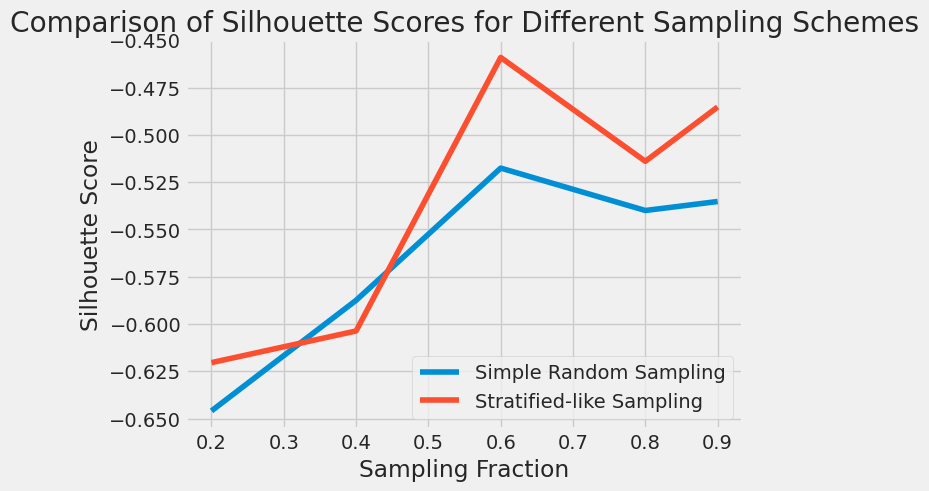

In [49]:

hotspots = pmdata
coords = hotspots.loc[:,['latitude','longitude']].values
#epsilon is the max distance points can be from each other to count as a cluster
kms_per_radian = 6371.0088
epsilon = 0.1 / kms_per_radian
# Define sampling fractions
sampling_fractions = [0.2, 0.4, 0.6, 0.8, 0.9]
def stratified_sampling(data, column, fraction):
    return data.groupby(column, group_keys=False).apply(lambda x: x.sample(frac=fraction))




# Lists to store silhouette scores
srs_scores = []
stratified_scores = []

for fraction in sampling_fractions:
    srs_sample = df.sample(frac=fraction, random_state=42)
    srs_labels = DBSCAN(eps=epsilon, min_samples=10, metric='haversine').fit_predict(np.radians(srs_sample[['latitude', 'longitude']]))
    srs_silhouette = silhouette_score(srs_sample[['latitude', 'longitude']], srs_labels)
    srs_scores.append(srs_silhouette)


    #Perform Stratified-like Sampling (you need to implement this)
    stratified_sample = stratified_sampling(df,'neighborhood', fraction)
    stratified_labels = DBSCAN(eps=epsilon, min_samples=10, metric='haversine').fit_predict(np.radians(stratified_sample[['latitude', 'longitude']]))
    stratified_silhouette = silhouette_score(stratified_sample[[ 'latitude', 'longitude']], stratified_labels)
    stratified_scores.append(stratified_silhouette)

# Plotting the results
plt.plot(sampling_fractions, srs_scores, label='Simple Random Sampling')
plt.plot(sampling_fractions, stratified_scores, label='Stratified-like Sampling')
plt.xlabel('Sampling Fraction')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Silhouette Scores for Different Sampling Schemes')
plt.legend()
plt.show()

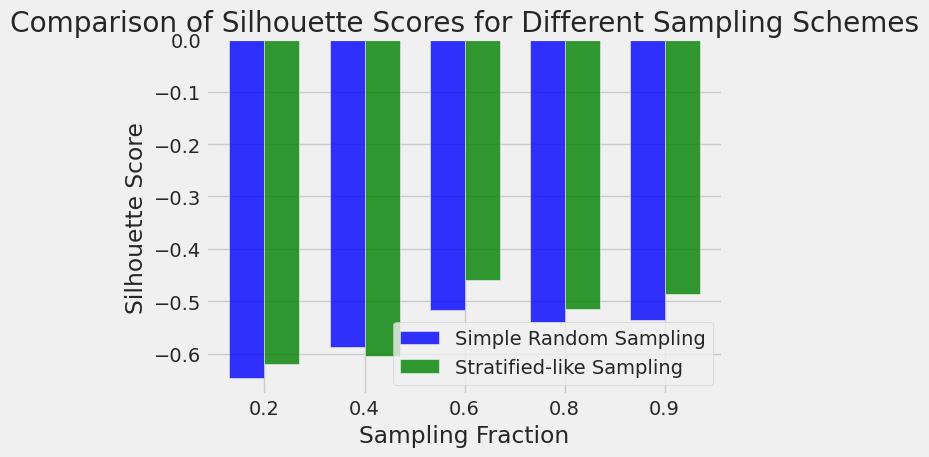

In [51]:
srs_scores = np.array(srs_scores)
stratified_scores = np.array(stratified_scores)

# Define the bar width
bar_width = 0.35

# Define the opacity
opacity = 0.8

# Define the bar positions
index = np.arange(len(sampling_fractions))

# Create the bars
plt.bar(index, srs_scores, bar_width, alpha=opacity, color='b', label='Simple Random Sampling')
plt.bar(index + bar_width, stratified_scores, bar_width, alpha=opacity, color='g', label='Stratified-like Sampling')

# Add labels, title, and legend
plt.xlabel('Sampling Fraction')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Silhouette Scores for Different Sampling Schemes')
plt.xticks(index + bar_width/2, sampling_fractions)  # Position x-axis labels
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

Now that we created some time series graphs, we will work on creating maps. Let's start with a PM2.5 map!

<font color='blue' size=12> Supervisor comments </font>: April 2, 2024
- TODO:
  - You have based your distance calculation by applying the stock version of DBSCAN in sickit-learn as-is, relying on using ```haversine``` as a distance metric to calculate haversine distances between coordinates (longitudes/latitudes pairs)
  > the attention that should be given in this case is that you did not capture any statistics regarding the distribution of the pm25 values (our target variable), you could for example capture the histograms of those values.
  Read more about possible values of ```pm2.5``` in this reference [PM2.5 particles in the air](https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm25-particles-in-the-air). This means that you need to create a histogram showing the density of each bracket, your binning strategy should rely on the community definition of ranges of values. For example, binning example is the follwoing: Less than 25, 25–50, 50–100, 100–300, More than 300. Simialr to what appears in the following figure:

<font color='Red' size=12> Modified code </font>: April 10, 2024

<font color='blue' size=12> Cont. Supervisor comments </font>: April 2, 2024
- TODO:
  - Also, draw histograms showing the same binning and density of pm2.5 values in each neighborhood in your data. By the way, how many neighborhoods you have in your data?!
  > this is important as it will inform us about the fact wether nearby locations are having similar pm25 values. Why do we need to do this, because it is only in that case we consider those as a cluster, since they are geographiclly nearby, and also having simialr feature values (pm25 in this case). So what you need to do next is the following:
  - .. ```Extract and normalize several features```, similar to what has been done in the following tutorial, read specifically [Extending DBSCAN beyond just spatial coordinates](https://musa-550-fall-2020.github.io/slides/lecture-11A.html), thereafter ```Run DBSCAN to extract high-density clusters``` passing as an argument to the DBSCAN the new ```scaled features```, probably something like ```cores, labels = dbscan(features, eps=eps, min_samples=min_samples)``` . notice passing features (including pm25, longitude, latitude) instead of simply the coordinates.
  - having done this novel distance calculation (based on geometrical distance and pm25 values distance), calculate again the ```silhouette_score```, and check wether you obtain a higher accuracy (higher silhouette_score values) or not!

  > **N.B.** we are able to do this because of the definition of ```metric``` in DBSCAN which says **metric: The metric to use when calculating distance between instances in** a ```feature array``` so, it  a distance between several features is possible, given a ```feature array```, so put your scaled features in a feature array.

  - one importance configurable parameter in this case is the distance metric.
  > you can use instead
    - most importantly the following : ```From scikit-learn: [‘cityblock’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’].```
    - and probably aome of the following ```From scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘rogerstanimoto’, ‘russellrao’,, ‘sokalmichener’, ‘sokalsneath’, ```

  - then, having permutate this configurable parameter, capture the ```silhouette_score``` and compare, then draw an x-y figure such as the following, (```you can do those graphs in MS excel after capturing the numbers```):

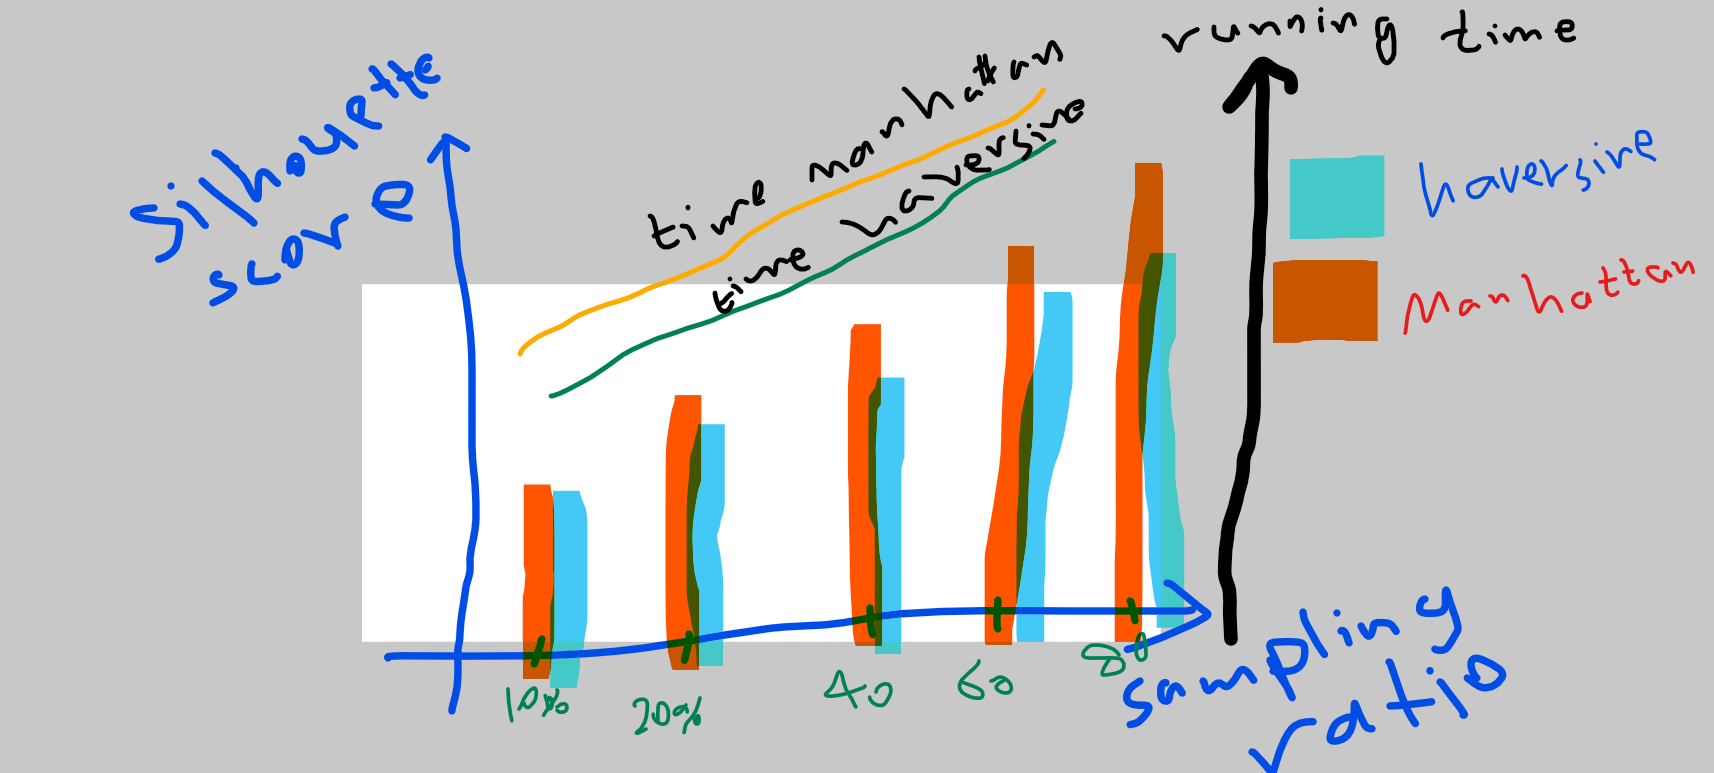

In [ ]:
feature_columns = [
    'pm25',
    'latitude',
    'longitude',
]
features = pmdata[feature_columns].copy()

In [ ]:
features.head()

,pm25,latitude,longitude
0,4.508813,40.847672,-73.869316
1,5.462420,40.847668,-73.869316
2,5.154881,40.847649,-73.869362
3,4.508813,40.847649,-73.869362
4,5.539503,40.847649,-73.869362


In [ ]:
# Scale these features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_features

array([[ 0.11025409,  1.24719128,  1.20027976],
       [ 0.64159613,  1.24695892,  1.20027976],
       [ 0.47023768,  1.24585524,  1.19790392],
       ..., 
       [ 1.20337967, -0.16569825,  0.1071878 ],
       [ 1.17745967, -0.1659306 ,  0.10677461],
       [ 1.23431808, -0.16633722,  0.10677461]])

In [ ]:
print(scaled_features.shape)
print(features.shape)

(169999, 3)
(169999, 3)


In [ ]:
#preprocessing for hotspot clustering
#we have to convert to radians, because scikit-learn’s haversine metric needs radian units
kms_per_radian = 6371.0088

#epsilon is the max distance points can be from each other to count as a cluster
epsilon = 0.1 / kms_per_radian
# Run DBSCAN
cores, labels = dbscan(features, eps=epsilon, min_samples=50)

# Add the labels back to the original (unscaled) dataset
features['label'] = labels
#cores, labels = dbscan(features, eps=eps, min_samples=min_samples)

In [ ]:
# Extract the number of clusters
num_clusters = features['label'].nunique() - 1
n_noise_ = list(features['label']).count(-1)

print("Estimated number of clusters: %d" % num_clusters)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 61
Estimated number of noise points: 164831


In [ ]:
# Get cluster sizes, from largest to smallest
N = features.groupby('label').size().sort_values(ascending=False)
print(N)
# Extract labels (ignoring label -1 for noise)
top5 = list(N.iloc[1:6].index)
print(top5)

In [ ]:

hotspots = pmdata
coords = hotspots.loc[:,['latitude','longitude']].values
#epsilon is the max distance points can be from each other to count as a cluster
kms_per_radian = 6371.0088
epsilon = 0.1 / kms_per_radian
# Define sampling fractions

sampling_fractions = [0.2, 0.4, 0.6, 0.8, 0.9]
def stratified_sampling(data, column, fraction):
    return data.groupby(column, group_keys=False).apply(lambda x: x.sample(frac=fraction))
# Lists to store silhouette scores
srs_scores = []
stratified_scores = []

for fraction in sampling_fractions:
    srs_sample = pmdata.sample(frac=fraction, random_state=42)
    srs_labels = DBSCAN(eps=epsilon, min_samples=50 ).fit_predict(np.radians(srs_sample[['latitude', 'longitude', 'pm25']]))
    #srs_labels = DBSCAN(eps=epsilon, min_samples=50, metric='haversine').fit_predict(np.radians(srs_sample[['latitude', 'longitude', 'pm25']]))
    srs_silhouette = silhouette_score(srs_sample[['latitude', 'longitude', 'pm25']], srs_labels)
    srs_scores.append(srs_silhouette)


    #Perform Stratified-like Sampling (you need to implement this)
    stratified_sample = stratified_sampling(pmdata,'neighborhood', fraction)
    stratified_labels = DBSCAN(eps=epsilon, min_samples=50).fit_predict(np.radians(stratified_sample[['latitude', 'longitude', 'pm25']]))
    stratified_silhouette = silhouette_score(stratified_sample[['latitude', 'longitude', 'pm25']], stratified_labels)
    stratified_scores.append(stratified_silhouette)

# Plotting the results
plt.plot(sampling_fractions, srs_scores, label='Simple Random Sampling')
plt.plot(sampling_fractions, stratified_scores, label='Stratified-like Sampling')
plt.xlabel('Sampling Fraction')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Silhouette Scores for Different Sampling Schemes')
plt.legend()
plt.show()

In [ ]:
srs_scores = np.array(srs_scores)
stratified_scores = np.array(stratified_scores)

# Define the bar width
bar_width = 0.35

# Define the opacity
opacity = 0.8

# Define the bar positions
index = np.arange(len(sampling_fractions))

# Create the bars
plt.bar(index, srs_scores, bar_width, alpha=opacity, color='b', label='Simple Random Sampling')
plt.bar(index + bar_width, stratified_scores, bar_width, alpha=opacity, color='g', label='Stratified-like Sampling')

# Add labels, title, and legend
plt.xlabel('Sampling Fraction')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Silhouette Scores for Different Sampling Schemes')
plt.xticks(index + bar_width/2, sampling_fractions)  # Position x-axis labels
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:

hotspots = pmdata
coords = hotspots.loc[:,['latitude','longitude']].values
#epsilon is the max distance points can be from each other to count as a cluster
kms_per_radian = 6371.0088
epsilon = 0.1 / kms_per_radian
# Define sampling fractions

sampling_fractions = [0.2, 0.4, 0.6, 0.8, 0.9]
def stratified_sampling(data, column, fraction):
    return data.groupby(column, group_keys=False).apply(lambda x: x.sample(frac=fraction))
# Lists to store silhouette scores
srs_scores = []
stratified_scores = []

for fraction in sampling_fractions:
    srs_sample = pmdata.sample(frac=fraction, random_state=42)
    srs_labels = DBSCAN(eps=epsilon, min_samples=50, metric='manhattan'  ).fit_predict(np.radians(srs_sample[['latitude', 'longitude', 'pm25']]))
    srs_silhouette = silhouette_score(srs_sample[['latitude', 'longitude', 'pm25']], srs_labels)
    srs_scores.append(srs_silhouette)


    #Perform Stratified-like Sampling (you need to implement this)
    stratified_sample = stratified_sampling(pmdata,'neighborhood', fraction)
    stratified_labels = DBSCAN(eps=epsilon, min_samples=50, metric='manhattan').fit_predict(np.radians(stratified_sample[['latitude', 'longitude', 'pm25']]))
    stratified_silhouette = silhouette_score(stratified_sample[['latitude', 'longitude', 'pm25']], stratified_labels)
    stratified_scores.append(stratified_silhouette)

# Plotting the results
plt.plot(sampling_fractions, srs_scores, label='Simple Random Sampling')
plt.plot(sampling_fractions, stratified_scores, label='Stratified-like Sampling')
plt.xlabel('Sampling Fraction')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Silhouette Scores for Different Sampling Schemes')
plt.legend()
plt.show()

In [ ]:
#Block 13
#hierarchical clustering code

# bottom-up hierarchical clustering - agglomerative, not k-means, because number of clusters not defined before
hotspots = pmdata
coords = hotspots.loc[:,['latitude','longitude']].values

#preprocessing for hotspot clustering
#we have to convert to radians, because scikit-learn’s haversine metric needs radian units
kms_per_radian = 6371.0088

#epsilon is the max distance points can be from each other to count as a cluster
epsilon = 0.1 / kms_per_radian

#min_samples is the minimum cluster size for a hotspot to be formed, and here we also call the haversine metric
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))-(1 if -1 in set(cluster_labels) else 0)
n_noise_ = list(cluster_labels).count(-1)
#outliers = coords[cluster_labels == -1]

print("Estimated number of clusters: %d" % num_clusters)
print("Estimated number of noise points: %d" % n_noise_)

#here is where we create the clusters after doing the background math above
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
#outliers = coords[cluster_labels == -1]
#print('Number of clusters: {}'.format(num_clusters))
#print('Number of outliers: {}'.format(outliers))



<font color='blue' size=12> Supervisor comments </font>: April 2, 2024
- TODO:
 - Provide a detailed explanation of the values you obtained for ```Silhouette Coefficient```
    - take some insights from [scikit-learn docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)
    - That is to say, >
    > "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar."

<font color='blue' size=12> Cont. Supervisor comments </font>: April 2, 2024
- TODO:
  - you need to do more analytics and Exploratory Spatio-Temporal Data Analytics (ESTDA,  read specifically [Extending DBSCAN beyond just spatial coordinates](https://musa-550-fall-2020.github.io/slides/lecture-11A.html), thereafter, for example ```Identify the 5 largest clusters``` , ```Get mean statistics for the top 5 largest clusters```, ```Visualize the top 5 largest clusters```, ```Visualizing one cluster at a time```.

##Resources and references


Papers:
*   [Challenges of Drive-By IoT Sensing for Smart Cities: City Scanner Case Study](https://senseable.mit.edu/papers/pdf/20181012_Anjomshooa-etal_ChallengesDrive-by_Purba.pdf)
*  [ City Scanner: Building and Scheduling a Mobile
Sensing Platform for Smart City Services](https://senseable.mit.edu/papers/pdf/20180522_Anjomshoaa-etal_CityScanner_IEEE-IoT.pdf)
* [Air quality monitoring using mobile low-cost sensors mounted on trashtrucks: Methods development and lessons learned](https://senseable.mit.edu/papers/pdf/20200601_deSouza-etal_AirQuality_SCS.pdf)



Python Library Documentation:
*  [Folium](http://python-visualization.github.io/folium/)
*  [Pandas](https://pandas.pydata.org/)
* [Matplotlib](https://matplotlib.org/)


